# Generate "clean" B cell subset

In this notebook, we'll read the cleaned PBMC reference dataset, select L1 cell types, and generate subset AnnData objects for each with updated UMAP projections.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [4]:
out_files = []

## Read annotated dataset

In [5]:
h5ad_uuid = '6e8972a5-9463-4230-84b4-a20de055b9c3'

In [6]:
adata = read_adata_uuid(h5ad_uuid)

In [7]:
adata.shape

(1823666, 1261)

## Generate B cell object

In [8]:
cell_class = 'b-cells'
keep_labels = ['B cell']

In [9]:
adata_subset = adata[adata.obs['AIFI_L1'].isin(keep_labels)]
adata_subset.shape

(160632, 1261)

In [10]:
obs = adata_subset.obs.copy()
obs['AIFI_L1'] = obs['AIFI_L1'].cat.remove_unused_categories()
obs['AIFI_L2'] = obs['AIFI_L2'].cat.remove_unused_categories()
obs['AIFI_L3'] = obs['AIFI_L3'].cat.remove_unused_categories()
adata_subset.obs = obs

### Re-project within the subset

In [11]:
adata_subset = adata_subset.raw.to_adata()

In [12]:
adata_subset.raw = adata_subset

In [13]:
sc.pp.normalize_total(adata_subset, target_sum = 1e4)

In [14]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)

In [15]:
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]].copy()

### Remove Ig Genes (for B cells only)

In [16]:
igl_genes = [gene for gene in adata_subset.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in adata_subset.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in adata_subset.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes

In [17]:
filtered_genes = [gene for gene in adata_subset.var_names if gene not in exl_genes]
adata_subset = adata_subset[:, filtered_genes]

In [18]:
sc.pp.scale(adata_subset)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [20]:
sce.pp.harmony_integrate(
    adata_subset, 
    'cohort.cohortGuid',
    max_iter_harmony = 30)

2024-03-09 22:06:15,003 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-09 22:07:37,344 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-09 22:07:38,196 - harmonypy - INFO - Iteration 1 of 30
2024-03-09 22:09:42,344 - harmonypy - INFO - Iteration 2 of 30
2024-03-09 22:13:19,329 - harmonypy - INFO - Iteration 3 of 30
2024-03-09 22:14:51,440 - harmonypy - INFO - Converged after 3 iterations


In [21]:
sc.pp.neighbors(
    adata_subset, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30)

In [22]:
sc.tl.umap(adata_subset, min_dist = 0.05)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


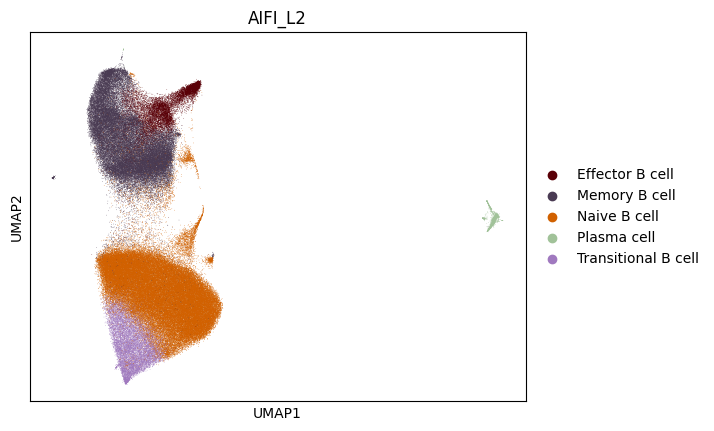

In [23]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


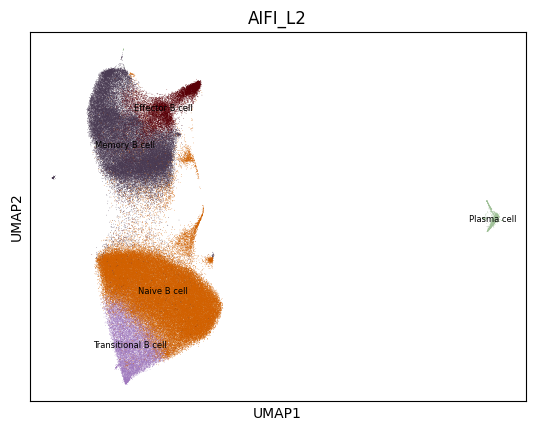

In [24]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


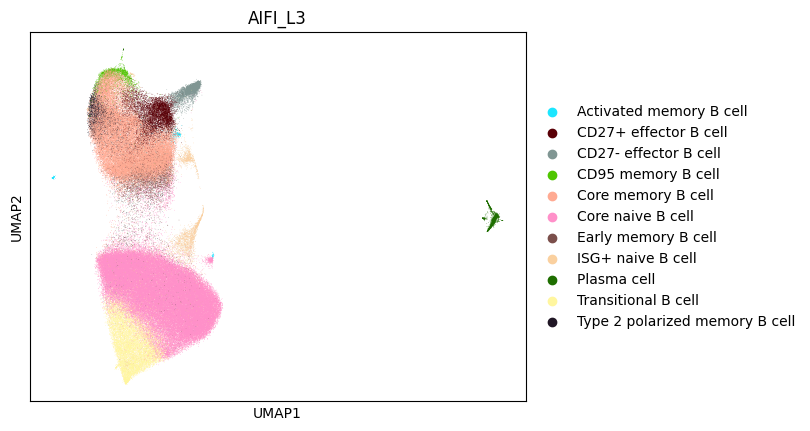

In [25]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


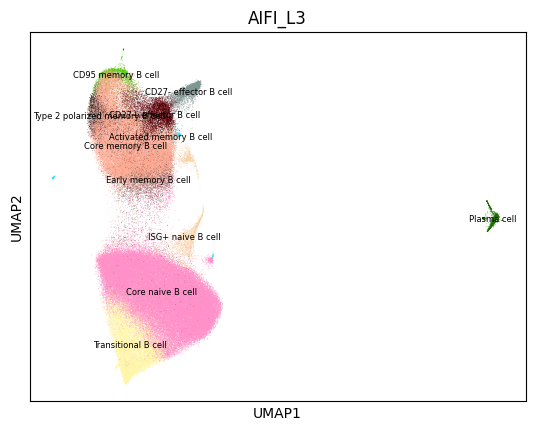

In [26]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

### Output subset annotations

In [27]:
obs = adata_subset.obs
obs = obs.reset_index(drop = True)

In [28]:
umap_mat = adata_subset.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [29]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden,AIFI_L1,AIFI_L2,AIFI_L3,keep,umap_1,umap_2
0,cf720af048b611ea8957bafe6d70929e,B001,patterny_untalented_halcyon,cf720af048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,928,66,7856,...,66,4.204693,2.798982,10,B cell,Memory B cell,Core memory B cell,True,-1.770064,5.381653
1,cf73500e48b611ea8957bafe6d70929e,B001,stressed_wishful_flea,cf73500e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1085,71,12422,...,71,4.276666,1.978267,7,B cell,Naive B cell,Core naive B cell,True,-2.670896,1.422507
2,cf73694a48b611ea8957bafe6d70929e,B001,silicone_nonsolar_snowgeese,cf73694a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1152,198,11355,...,198,5.293305,5.899881,10,B cell,Effector B cell,CD27+ effector B cell,True,-1.056543,7.004561
3,cf73fbee48b611ea8957bafe6d70929e,B001,luxuriant_overrated_gypsymoth,cf73fbee48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1769,245,18105,...,245,5.505332,4.552211,7,B cell,Transitional B cell,Transitional B cell,True,-0.790140,-1.377115
4,cf74ae2c48b611ea8957bafe6d70929e,B001,real_bighearted_kitty,cf74ae2c48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,692,83,5468,...,83,4.430817,4.976019,7,B cell,Naive B cell,Core naive B cell,True,-3.119497,1.496835


In [30]:
obs_out_csv = '{p}/ref_clean_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)
out_files.append(obs_out_csv)

In [31]:
obs_out_parquet = '{p}/ref_clean_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)
out_files.append(obs_out_parquet)

### Output subset AnnData

In [32]:
out_h5ad = '{p}/ref_clean_pbmc_{c}_labeled_{d}.h5ad'.format(p = out_dir, c = cell_class, d = date.today())
adata_subset.write_h5ad(out_h5ad)
out_files.append(out_h5ad)

## Upload results to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [33]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'PBMC Clean Reference B cells {d}'.format(d = date.today())

In [34]:
in_files = [h5ad_uuid]

In [35]:
in_files

['6e8972a5-9463-4230-84b4-a20de055b9c3']

In [36]:
out_files

['output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.csv',
 'output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.parquet',
 'output/ref_clean_pbmc_b-cells_labeled_2024-03-09.h5ad']

In [37]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.csv
output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.parquet
output/ref_clean_pbmc_b-cells_labeled_2024-03-09.h5ad
Cannot determine the current notebook.
1) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/26-Python_clean_NK_cell_projections.ipynb
2) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/25-Python_clean_Myeloid_cell_projections.ipynb
3) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/24-Python_clean_B_cell_projections.ipynb
Please select (1-3) 


 3


you are trying to upload file_ids... ['output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.csv', 'output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.parquet', 'output/ref_clean_pbmc_b-cells_labeled_2024-03-09.h5ad']. Do you truly want to proceed?


(y/n) y


{'trace_id': '866cda28-b653-49d2-a334-ee76745dc5ac',
 'files': ['output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.csv',
  'output/ref_clean_pbmc_b-cells_labeled_meta_umap_2024-03-09.parquet',
  'output/ref_clean_pbmc_b-cells_labeled_2024-03-09.h5ad']}

In [38]:
import session_info
session_info.show()